**DISCLAIMER:** For viewing purposes only; this notebook will not run without SFUSD data in '../data/'.

# Packages and plot settings

In [1]:
import numpy as np
import pandas as pd
import stratified_pytorch as sp
import data_processing as dp
import torch as t
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
tqdm.pandas()

from scipy.special import softmax
from scipy.stats import weightedtau, entropy
from joblib import Parallel, delayed

import ast
import copy
import importlib
import itertools
import os
import re
import sys
from glob import glob

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style='whitegrid', rc={'grid.alpha': 0.25, 'text.usetex': False})
palette = sns.color_palette('Greys', n_colors=1) + sns.color_palette(n_colors=4)

# Define macros

In [3]:
# Years for train & test
TRAIN_YEAR = '1718'
TEST_YEAR = '1819'

# Where Avg Color Index and greatschools data lives:
TRAIN_SCHOOL_ATTS_PATH = '../data/schools_rehauled_1718.csv'
TEST_SCHOOL_ATTS_PATH = '../data/schools_rehauled_1819.csv'

# Where bus route and PTA data lives:
DETAILED_SCHOOL_ATTS_PATH = '../data/SFUSD School Characteristics - School Data.csv'

# Where program data lives:
TRAIN_PROGRAM_ATTS_PATH = '../data/programs_1718.csv'
TEST_PROGRAM_ATTS_PATH = '../data/programs_1819.csv'

# Students x schools individual travel (driving?) times
DISTANCES_PATH = '../data/distances.csv' # (n_students, n_schools)
WALK_TIMES_TO_BG_PATH = '../data/bg_to_school_walk_time.csv' # (n_students, n_schools)

# Relevant choice data
STUDENT_DATA_TRAIN = '../data/student_1718.csv'
STUDENT_DATA_TEST = '../data/student_1819.csv'

# Load school attributes

PTA fund, bus-route, before- and after-school program data:

In [4]:
detailed_school_attributes = pd.read_csv(DETAILED_SCHOOL_ATTS_PATH, index_col="School Code")

In [5]:
detailed_school_attributes['PTA_Funds_Per_Pupil'] = [float(re.sub(r'[^\d.]', '', amount)) for amount in detailed_school_attributes['Annual PTA funds per pupil']]
detailed_school_attributes['School bus from'] = detailed_school_attributes['School bus from'].fillna('[]')
detailed_school_attributes['School bus from K'] = detailed_school_attributes['School bus from']

In [6]:
# Manual fixes and entries
detailed_school_attributes.loc[796, 'School bus from K'] = '94110, 94124, 94134'
detailed_school_attributes.loc[479, 'School bus from K'] = '94102, 94115, 94124'
detailed_school_attributes.loc[876, 'Has Before School Programs'] = 'No'
detailed_school_attributes.loc[876, 'Has After School Programs'] = 'Yes'

In [7]:
detailed_school_attributes['School bus from K'] = detailed_school_attributes['School bus from K'].apply(lambda x: ast.literal_eval(x))

Average color data:

In [8]:
school_attributes_train = pd.read_csv(TRAIN_SCHOOL_ATTS_PATH, index_col='school_id')

In [9]:
for column in ['ela_color', 'math_color', 'chronic_color', 'suspension_color']:
    school_attributes_train[column].replace(['Red', 'Orange', 'Yellow', 'Green', 'Blue'], [1.,2.,3.,4.,5.], inplace=True)
school_attributes_train['AvgColorIndex'] = school_attributes_train[['ela_color', 'math_color', 'chronic_color', 'suspension_color']].mean(numeric_only=True, axis=1)
school_attributes_train['% FRL 2019-2022'] = detailed_school_attributes.loc[school_attributes_train.index,'% FRL']
school_attributes_train['PTA funds per pupil'] = detailed_school_attributes.loc[school_attributes_train.index,'PTA_Funds_Per_Pupil']
school_attributes_train['has_before_school_progs'] = detailed_school_attributes.loc[school_attributes_train.index,'Has Before School Programs'].map({'Yes':1, 'No':0})
school_attributes_train['has_after_school_progs'] = detailed_school_attributes.loc[school_attributes_train.index,'Has After School Programs'].map({'Yes':1, 'No':0})

Program specific data:

In [10]:
prog_to_nest = {'GE': 'General Education', 'MM': 'Special Education','MS': 'Special Education',
                'SA': 'Special Education', 'AF': 'Special Education', 'ED': 'Special Education', 
                'DA': 'Special Education', 'DT': 'Special Education', 'SN': 'Spanish Language',
                'SE': 'Spanish Language', 'NS': 'Spanish Language', 'SB': 'Spanish Language',
                'CE': 'Chinese Language', 'CN': 'Chinese Language', 'ME': 'Chinese Language',
                'MN': 'Chinese Language', 'CT': 'Chinese Language', 'NC': 'Chinese Language',
                'CB': 'Chinese Language', 'JN': 'Japanese Language', 'JB': 'Japanese Language',
                'JE': 'Japanese Language', 'KE': 'Korean Language', 'KN': 'Korean Language',
                'FB': 'Filipino Language'}

In [11]:
program_attributes_train = pd.read_csv(TRAIN_PROGRAM_ATTS_PATH, index_col='program_id')
program_attributes_train['school_id'] = program_attributes_train.school_id.astype(int)
program_attributes_train['nest_membership'] = [prog_to_nest[program_type] for program_type in program_attributes_train['program_type']]
program_attributes_train['AvgColorIndex'] = [school_attributes_train.loc[school,'AvgColorIndex'] for school in program_attributes_train.school_id]
program_attributes_train['portion_FRL'] = [school_attributes_train.loc[school,'% FRL 2019-2022']/100. for school in program_attributes_train.school_id]
program_attributes_train['has_before_school_progs'] = [school_attributes_train.loc[school,'has_before_school_progs'] for school in program_attributes_train.school_id]
program_attributes_train['has_after_school_progs'] = [school_attributes_train.loc[school,'has_after_school_progs'] for school in program_attributes_train.school_id]

In [12]:
cat=pd.Categorical(program_attributes_train['nest_membership'])
nests = list(cat.categories)
program_attributes_train['nest_id'] = cat.codes
program_attributes_train.head()

Unnamed: 0  school_id program_type  capacity  r2_capacity  \
program_id                                                              
413-GE-KG            0        413           GE        88           92   
413-SA-KG            1        413           SA         2            2   
420-GE-KG            2        420           GE        44           44   
420-MS-KG            3        420           MS         4            4   
420-SE-KG            4        420           SE        18           18   

            r3_capacity  r1_assigned  r1_noenroll  r1_first_choice  \
program_id                                                           
413-GE-KG            88         88.0         18.0             89.0   
413-SA-KG             2          1.0          0.0              1.0   
420-GE-KG            42         44.0         16.0             44.0   
420-MS-KG             4          3.0          0.0              3.0   
420-SE-KG            18         18.0          3.0             69.0   

              nest_membership  AvgColorIndex  portion_FRL  \
program_id                                                  
413-GE-KG   General Education            3.5     0.367206   
413-SA-KG   Special Education            3.5     0.367206   
420-GE-KG   General Education            3.5     0.295983   
420-MS-KG   Special Education            3.5     0.295983   
420-SE-KG    Spanish Language            3.5     0.295983   

            has_before_school_progs  has_after_school_progs  nest_id  
program_id                                                            
413-GE-KG                         0                       1        2  
413-SA-KG                         0                       1        6  
420-GE-KG                         1                       1        2  
420-MS-KG                         1                       1        6  
420-SE-KG                         1                       1        5

# Load travel data

Student-school sqrt. distances (miles):

In [13]:
distances = pd.read_csv(DISTANCES_PATH,index_col=0)
distances.columns = distances.columns.astype(int)
sqrt_distances = np.sqrt(distances)
program_sqrt_distances = sqrt_distances.loc[distances.index, program_attributes_train.school_id]
program_sqrt_distances.columns = program_attributes_train.index

Block-school walk time (minutes):

In [14]:
bg_to_school_walktime = pd.read_csv(WALK_TIMES_TO_BG_PATH, index_col='origin_bg')
bg_to_school_walktime.columns = bg_to_school_walktime.columns.astype(int)

Helper dict for language-related covariate later:

In [15]:
lang_to_program = {'CC-Chinese Cantonese': ['CB','CE','CN','CT', 'NC'],
                   'SP-Spanish': ['SB','SE','SN','NS'],
                   'CM-Chinese Mandarin': ['ME','MN'],
                   'JA-Japanese': ['JE','JN'],
                   'KO-Korean': ['KE','KN'],
                   'FT-Filipino Tagalog': ['FB'],
                   'FI-Filipino Ilocano': ['FB']}

In [16]:
program_to_language = {item: k for k, v in lang_to_program.items() for item in v}

# Load preference data

Mapping reported ethnicity to EdData racial categories: 
https://www.ed-data.org/article/Ethnic-Diversity-Index#:~:text=Diversity%20Index%20calculated%3F-,What%20is%20the%20Ethnic%20Diversity%20Index%3F,groups%20in%20its%20student%20population.

In [17]:
def aggregate_ethnicities(row):
    if row['resolved_ethnicity'] in ['Decline to State']:
        return 'Decline to State'
    elif row['resolved_ethnicity'] in ['Black or African American']:
        return 'Black or African American'
    elif row['resolved_ethnicity'] in ['American Indian or Alaskan Native']:
        return 'American Indian or Alaskan Native'
    elif row['resolved_ethnicity'] in ['Asian', 'Asian Indian', 'Chinese', 'Korean', 'Vietnamese', 'Cambodian', 'Japanese', 'Other Asian']:
        return 'Asian'
    elif row['resolved_ethnicity'] in ['Hispanic/Latino']:
        return 'Hispanic/Latino'
    elif row['resolved_ethnicity'] in ['Filipino']:
        return 'Filipino'
    elif row['resolved_ethnicity'] in ['Pacific Islander', 'Other Pacific Islander', 'Samoan']:
        return 'Pacific Islander'
    elif row['resolved_ethnicity'] in ['White', 'Middle Eastern/Arabic']:
        return 'White'
    elif row['resolved_ethnicity'] in ['Two or More Races']:
        return 'Two or More Races'

Train and test ranking data:

In [18]:
data1 = pd.read_csv(STUDENT_DATA_TRAIN)
data1['year'] = TRAIN_YEAR
data2 = pd.read_csv(STUDENT_DATA_TEST)
data2['year'] = TEST_YEAR
raw_data = pd.concat([data1, data2], ignore_index=True, sort=False)

/tmp/ipykernel_2964353/3901081731.py:1: DtypeWarning: Columns (2,3,4,6,11,12,13,14,15,16,17,18,71,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv(STUDENT_DATA_TRAIN)
/tmp/ipykernel_2964353/3901081731.py:3: DtypeWarning: Columns (2,3,4,6,11,12,13,14,58) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv(STUDENT_DATA_TEST)


In [19]:
df = raw_data[raw_data.grade=='KG'].dropna(subset=['studentno'])
df = df[df.census_blockgroup.isin(bg_to_school_walktime.index)]
df['first_participated_round'] = (~df[['r1_programs', 'r2_programs', 'r3_programs', 'r5_programs']].isna()).apply(lambda x: np.where(x)[0][0]+1, axis=1)
df['first_participated_round'] = [roundd if roundd!= 4 else 5 for roundd in df['first_participated_round']]                                      
for col in ['r1_ranked_idschool', 'r2_ranked_idschool', 'r3_ranked_idschool', 'r5_ranked_idschool',
            'r1_programs', 'r2_programs', 'r3_programs', 'r5_programs',
            'r1_listed_ranks', 'r2_listed_ranks', 'r3_listed_ranks', 'r5_listed_ranks',
            'sibling', 'aaprek', 'aa']:
    df[col] = df[col].fillna(value='[]').apply(lambda x: ast.literal_eval(x))
df['idschoolattendance'] = df['idschoolattendance'].apply(lambda x: int(x))
df['freelunch_prob_group'] = pd.qcut(df['freelunch_prob'],
                                q=[0, 1/2, 1],
                                labels=['low', 'high']) 
df['r1_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r1_ranked_idschool'], df['r1_programs'])]
df['r2_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r2_ranked_idschool'], df['r2_programs'])]
df['r3_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r3_ranked_idschool'], df['r3_programs'])]
df['r5_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r5_ranked_idschool'], df['r5_programs'])]
df['first_ranked_programs'] = [row['r'+str(row['first_participated_round'])+'_ranked_programs'] for _, row in df.iterrows()]
df['normed_ethnicity'] = df.apply(aggregate_ethnicities, axis=1)

# Repeated selection

Convert rankings to individual choices via repeated selection:

In [20]:
dff = df[df.year==TRAIN_YEAR]
dataset = dp.clean_dataframe(dff, program_attributes_train, program_sqrt_distances)
choices, student_codex, program_codex, ctip_codex, ballot = dp.prep_dataset(dataset, program_attributes_train)

In [21]:
school_codex=list(program_attributes_train.loc[program_codex,'school_id'].values)
assert(len(school_codex)==len(program_codex))

In [22]:
num_programs = len(program_codex)
num_students = len(student_codex)
print('No. students: ', num_students)
print('No. programs: ', num_programs)
print('Avg. len of ranking', dataset.num_ranked.mean())
print('No. training examples', choices[0].shape[0])
print('% CTIP1', ctip_codex.mean())

No. students:  5019
No. programs:  154
Avg. len of ranking 9.903367204622434
No. training examples 48714
% CTIP1 0.16676628810520025


# Covariates

Calculate $d$ matrices of size $(n,m)$ of $d$ individual covariates:

In [23]:
busroutes_lookup = pd.DataFrame(0, index = df.zipcode.unique(), columns=program_sqrt_distances.columns)
for program in program_attributes_train.index:
    school = program_attributes_train.loc[program, 'school_id']
    zip_list = detailed_school_attributes.loc[school, 'School bus from K']
    busroutes_lookup.loc[zip_list, program] = 1

In [24]:
bg_to_prog_walktime = bg_to_school_walktime.loc[bg_to_school_walktime.index, program_attributes_train.school_id]
bg_to_prog_walktime.columns = program_attributes_train.index
bg_to_prog_walktime.head(2)

program_id     413-GE-KG   413-SA-KG  420-GE-KG  420-MS-KG  420-SE-KG  \
origin_bg                                                               
6.075010e+10  103.181533  103.181533  92.355933  92.355933  92.355933   
6.075010e+10  101.583600  101.583600  90.122400  90.122400  90.122400   

program_id    420-SN-KG   435-GE-KG  456-GE-KG  456-SB-KG  618-MM-KG  ...  \
origin_bg                                                             ...   
6.075010e+10  92.355933  106.858933  87.275667  87.275667  82.985133  ...   
6.075010e+10  90.122400  105.261000  84.842067  84.842067  80.751600  ...   

program_id    497-GE-KG  497-SE-KG  497-SN-KG   876-CE-KG   876-CN-KG  \
origin_bg                                                               
6.075010e+10  74.362267  74.362267  74.362267  130.428933  130.428933   
6.075010e+10  71.928667  71.928667  71.928667  128.195400  128.195400   

program_id     876-GE-KG  801-GE-KG  801-SA-KG   485-CE-KG   485-CT-KG  
origin_bg                                                               
6.075010e+10  130.428933    11.6044    11.6044  118.252933  118.252933  
6.075010e+10  128.195400     9.7716     9.7716  116.064400  116.064400  

[2 rows x 158 columns]

In [25]:
busroutes = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
walking_time = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
siblings = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
aaprek = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
aa = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
langprograms = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
for i, row in df.iterrows():
    student = row['studentno']
    if student not in program_sqrt_distances.index:
        continue
    zipcode = row.loc['zipcode']
    lang = row.loc['homelang_desc']
    bg = row.loc['census_blockgroup']
    sibling_list = row.loc['sibling']
    prek = row.loc['aaprek']
    aa_school = row.loc['idschoolattendance']
    busroutes.loc[student, :] = busroutes_lookup.loc[zipcode,:]

    walking_time.loc[student, :] = bg_to_prog_walktime.loc[bg,:].astype(int)

    program_series = program_attributes_train[program_attributes_train.school_id==aa_school].index
    aa.loc[student, program_series] += 1

    program_series = program_attributes_train[program_attributes_train.school_id.isin(prek)].index
    aaprek.loc[student, program_series] += 1

    program_series = program_attributes_train[program_attributes_train.school_id.isin(sibling_list)].index
    siblings.loc[student, program_series] += 1

    if (lang in ['CC-Chinese Cantonese', 'SP-Spanish', 'CM-Chinese Mandarin', 'JA-Japanese', 'KO-Korean', 'FT-Filipino Tagalog', 'FI-Filipino Ilocano']):
        program_series = program_attributes_train[program_attributes_train.program_type.isin(lang_to_program[lang])].index
        langprograms.loc[student, program_series] += 1

Function to stack $d$ covariate matrices into single $(n,m,d)$ ndarray:

In [26]:
def generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex):
    n=len(program_codex)
    
    # School/program atts
    avg_color = np.array(program_attributes.loc[program_codex, 'AvgColorIndex']).reshape(1,n)
    before_after_school = np.array(program_attributes.loc[program_codex, 'has_after_school_progs']|program_attributes.loc[program_codex, 'has_before_school_progs']).reshape(1,n)
    frl = np.array(program_attributes.loc[program_codex, 'portion_FRL']).reshape(1,n)

    # Student/program atts
    avg_color_nonCTIP = np.multiply((~ctip_codex)[:,None], avg_color)[:,:,None]
    avg_color_CTIP = np.multiply((ctip_codex)[:,None], avg_color)[:,:,None]
    frl_nonCTIP = np.multiply((~ctip_codex)[:,None], frl)[:,:,None]
    frl_CTIP = np.multiply((ctip_codex)[:,None], frl)[:,:,None]
    beforeafter_nonCTIP = np.multiply((~ctip_codex)[:,None], before_after_school)[:,:,None]
    beforeafter_CTIP = np.multiply((ctip_codex)[:,None], before_after_school)[:,:,None]
    sqrt_program_distances = np.array(program_sqrt_distances.loc[student_codex, program_codex])[:,:,None]
    bus_route = np.array(busroutes.loc[student_codex, program_codex])[:,:,None]
    within_15min_walk = np.array(walking_time.loc[student_codex, program_codex]<=15.)[:,:,None]
    sibling_match = np.array(siblings.loc[student_codex, program_codex])[:,:,None]
    aaprek_match = np.array(aaprek.loc[student_codex, program_codex])[:,:,None]
    aa_match = np.array(aa.loc[student_codex, program_codex])[:,:,None]
    language_match = np.array(langprograms.loc[student_codex, program_codex])[:,:,None]
    return np.dstack([avg_color_nonCTIP,
                      avg_color_CTIP,
                      frl_nonCTIP,
                      frl_CTIP,
                      beforeafter_nonCTIP,
                      beforeafter_CTIP,
                      sqrt_program_distances,
                      within_15min_walk,
                      bus_route,
                      sibling_match,
                      language_match,
                      aa_match,
                      aaprek_match]).astype(np.float32)

In [27]:
covariate_names = ['Avg. Color, non-CTIP', 'Avg. Color, CTIP', 
                   'FRL, non-CTIP', 'FRL, CTIP', 
                   'Before/after school prog, non-CTIP', 'Before/after school prog, CTIP',
                   'Sqrt. distance', 'Within 15 min walk', 
                   'Exists bus route', 'Sib. Match', 'Lang. Match', 
                   'AA', 'PreK/TK']

# Figure 6 & 7: Hyperparameter tuning

In [28]:
def compute_null_loss(x, x_extra, y, num_ranks=5):
    batch_size, seq_len, _ = x.size()
    y_hat = F.log_softmax(t.zeros((batch_size, seq_len, 1)), 1)
    terms = []
    for i in range(num_ranks):
        rows = x_extra[:,2]==i
        terms.append(F.nll_loss(y_hat[rows], y[rows, None].long()).detach().numpy())
    return (F.nll_loss(y_hat, y[:, None].long()), terms)

5-fold cross validation:

In [29]:
kfolds=5
shuffled = dataset.sample(frac=1).reset_index(drop=True)
folds = np.array_split(shuffled, kfolds)

## Figure 6a: Sweep over local regularization

Scanning $\lambda$ over $[1e-5,1e-4,1e-3,1e-2,1e-1,1.0]$:

In [30]:
def reg_sweep(i, wd, model_name, fixed_effect, linear, context):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = dp.prep_dataset(train, program_attributes_train)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = dp.prep_valset(val, program_attributes_train, train_prog_codex)
  
    X_train = generate_covariate_matrix(program_attributes_train, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes_train, val_st_codex, train_prog_codex, val_ctip_codex)

    '''
    Train and validate models
    '''
    if model_name=='nested':
        nest_memberships = program_attributes_train.loc[train_prog_codex,'nest_id'].values
        kwargs={'fixed_effects': True,
                'linear_terms': True,
                'covariates': X_train,
                'num_nests': len(nests),
                'nest_memberships': nest_memberships}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                            num_items=len(train_prog_codex), 
                                                            epochs=1000, 
                                                            lr=1e-4 if (wd==1e-1) else 1e-5 if (wd==1e-2) else 1e-3, 
                                                            wd=wd, 
                                                            verbose=True, 
                                                            Model=sp.NestedMNL,
                                                            **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        result.append([model_name, i, wd, 'train', tr_loss, num_epochs, no_params])
        yval_hat = model.forward(xval, xlval, X_val)
        v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
        result.append([model_name, i, wd, 'val', v_loss, num_epochs, no_params])
        return result    
    else:
        kwargs={'fixed_effects': fixed_effect,
                'linear_terms': linear,
                'covariates': X_train,
                'context': context,
                'k': 1}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                            num_items=len(train_prog_codex), 
                                                            epochs=1000, 
                                                            lr=1e-3, 
                                                            wd=wd, 
                                                            verbose=True, 
                                                            **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
        result.append([model_name, i, wd, 'train', tr_loss, num_epochs, no_params])
        yval_hat = model.forward(xval, xlval, X_val)
        v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
        result.append([model_name, i, wd, 'val', v_loss, num_epochs, no_params])
        return result

In [ ]:
wds=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
model_names = ['fixed', 'linear', 'cdm', 'nested']
fixed_effects = [True, True, True, True]
linears = [False, True, True, True]
contexts = [False, False, True, False]
wd_results = Parallel(n_jobs=-4)(delayed(reg_sweep)(i, wd, model_name, fe, linear, context) 
                                 for i in range(kfolds) 
                                 for wd in wds 
                                 for model_name, fe, linear, context in zip(model_names, 
                                                                            fixed_effects, 
                                                                            linears, 
                                                                            contexts))
wd_results = [subitem for item in wd_results for subitem in item]

/home/ameloa/school_choice_project/arjun_cdm/data_processing.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['student_id'] = cat.codes
/home/ameloa/school_choice_project/arjun_cdm/data_processing.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['student_id'] = cat.codes
/home/ameloa/school_choice_project/arjun_cdm/data_processing.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
wd_results = pd.DataFrame(wd_results, columns=['model', 
                                               'fold', 
                                               'weight decay', 
                                               'loss type', 
                                               'loss', 
                                               'num epochs', 
                                               'no params'])
wd_results['loss'] = wd_results['loss'].astype(float)
wd_results['weight decay'] = wd_results['weight decay'].astype(float)
wd_results

In [ ]:
pd.pivot_table(data=wd_results[wd_results['loss type']=='val'], values='loss', index='model', columns='weight decay')

In [ ]:
custom_lines = [Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
custom_labels = ['fixed, train', 
                 'fixed, val', 
                 'linear, train', 
                 'linear, val', 
                 'nested, train', 
                 'nested, val', 
                 'CDM, train', 
                 'CDM, val', ]
fig=plt.figure()
sns.lineplot(data=wd_results, x='weight decay', y='loss', hue='model', 
             style='loss type', style_order=['val', 'train'], marker='o')
plt.xscale('log')
plt.xlabel(r'Local regularization, $\lambda$')
plt.ylabel(r'NLL')
plt.legend(custom_lines, custom_labels, loc='lower right')
fig.savefig('../Figs/local_reg.pdf', format='pdf', bbox_inches='tight')

## Figure 6b: CDM rank sweep over embedding_dim

Scanning $r$ over $[2,...,10]$:

In [42]:
def rank_sweep(i, dim):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = dp.prep_dataset(train, program_attributes_train)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = dp.prep_valset(val, program_attributes_train, train_prog_codex)

    '''
    Train and validate models
    '''
    X_train = generate_covariate_matrix(program_attributes_train, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes_train, val_st_codex, train_prog_codex, val_ctip_codex)
    kwargs={'fixed_effects': True,
            'linear_terms': True,
            'covariates': X_train,
            'context': True,
            'embedding_dim': dim,
            'k': 1}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                        num_items=len(train_prog_codex), 
                                                        epochs=1000, 
                                                        lr=1e-3, 
                                                        wd=1e-5, 
                                                        verbose=True, 
                                                        **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
    result.append([i, dim, 'train', tr_loss, num_epochs, no_params])
    yval_hat = model.forward(xval, xlval, X_val)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval)
    result.append([i, dim, 'val', v_loss, num_epochs, no_params])
    return result

In [ ]:
cdm_results = Parallel(n_jobs=-4)(delayed(rank_sweep)(i, dim) for i in range(kfolds) for dim in range(2,11))

In [ ]:
cdm_results = [subitem for item in cdm_results for subitem in item]
cdm_results = pd.DataFrame(cdm_results, columns=['fold', 'embedding dim', 'loss type', 'loss', 'num epochs', 'no params'])
cdm_results['loss'] = cdm_results['loss'].astype(float)
cdm_results['embedding dim'] = cdm_results['embedding dim'].astype(int)
cdm_results

In [ ]:
cdm_results.pivot_table(index='embedding dim', columns='loss type', values='loss')

In [ ]:
custom_lines = [Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
custom_labels = ['CDM, train', 
                 'CDM, val', ]
fig=plt.figure()
sns.lineplot(data=cdm_results, x='embedding dim', y='loss', style='loss type', 
             style_order = ['val', 'train'], color=sns.color_palette()[2])
plt.xlabel(r'CDM embedding dimension, $r$')
plt.ylabel(r'NLL')
plt.legend(custom_lines, custom_labels)
fig.savefig('../Figs/cdm_rank.pdf', format='pdf', bbox_inches='tight')

## Figure 7: Stratification hyperparameter sweep

Scanning $k$ over $[2,...,10]$ and $\lambda_\mathcal{L}$ over $[0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]$:

In [ ]:
def strat_sweep(i, k, lambda_reg, lr, model_name, fixed_effect, linear, context):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = dp.prep_dataset(train, program_attributes_train)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = dp.prep_valset(val, program_attributes_train, train_prog_codex)
    
    X_train = generate_covariate_matrix(program_attributes_train, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes_train, val_st_codex, train_prog_codex, val_ctip_codex)
    kwargs={'fixed_effects': fixed_effect,
            'linear_terms': linear,
            'covariates': X_train,
            'context': context,
            'embedding_dim': 10,
            'k': k,
            'lambda_reg': lambda_reg}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                        num_items=len(train_prog_codex), 
                                                        epochs=1000, 
                                                        lr=lr, 
                                                        wd=1e-5, 
                                                        verbose=True, 
                                                        **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
    task_loss = tr_loss - np.array(tr_losses)[-1, -1]
    result.append([model_name, i, k, lambda_reg, lr, 'train', task_loss, num_epochs, no_params])
    result.append([model_name, i, k, lambda_reg, lr, 'train + reg', tr_loss, num_epochs, no_params])
    yval_hat = model.forward(xval, xlval, X_val)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
    result.append([model_name, i, k, lambda_reg, lr, 'val', v_loss, num_epochs, no_params])
    return result

In [ ]:
lambdas = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.]
lrs = [1e-3, 1e-3, 1e-3, 1e-3, 5e-4, 5e-4, 5e-4]
model_names = ['fixed', 'linear', 'cdm']
fixed_effects = [True, True, True]
linears = [False, True, True]
contexts = [False, False, True]

strat_results = Parallel(n_jobs=30)(delayed(strat_sweep)(i, k, lambda_reg, lr, model_name, fe, linear, context) 
                                    for i in range(kfolds) 
                                    for k in range(2,11) 
                                    for (lambda_reg, lr) in zip(lambdas, lrs)
                                    for model_name, fe, linear, context in zip(model_names, 
                                                                               fixed_effects, 
                                                                               linears, 
                                                                                contexts))
strat_results = [item for sublist in strat_results for item in sublist]

In [ ]:
strat_results_df = pd.DataFrame(strat_results, columns=['model', 'fold', 'k', 'lambda', 'lr', 'loss type', 'loss', 'num epochs', 'no params'])

In [ ]:
results2 = Parallel(n_jobs=30)(delayed(strat_sweep)(i, 1, 0.0, 1e-3, model_name, fe, linear, context) 
                               for i in range(kfolds) 
                               for model_name, fe, linear, context in zip(model_names, 
                                                                          fixed_effects, 
                                                                          linears, 
                                                                          contexts))
results2 = [item for sublist in results2 for item in sublist]
results2 = pd.DataFrame(results2, columns=['model','fold', 'k', 'lambda', 'lr', 'loss type', 'loss', 'num epochs', 'no params'])
strat_results_df2 = pd.concat([strat_results_df, results2])

In [ ]:
df_pl = strat_results_df2[strat_results_df2['model']=='fixed']
df_linear = strat_results_df2[strat_results_df2['model']=='linear']
df_cdm = strat_results_df2[strat_results_df2['model']=='cdm']

In [ ]:
df_pl['loss']=df_pl.loss.astype(float)
df_linear['loss']=df_linear.loss.astype(float)
df_cdm['loss']=df_cdm.loss.astype(float)

In [ ]:
pl_palette = sns.light_palette(sns.color_palette()[0], as_cmap=True)
linear_palette = sns.light_palette(sns.color_palette()[1], as_cmap=True)
cdm_palette = sns.light_palette(sns.color_palette()[2], as_cmap=True)

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(18, 10), sharex=True, sharey=True)

pt_pl = pd.pivot_table(df_pl[df_pl['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_linear = pd.pivot_table(df_linear[df_linear['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_cdm = pd.pivot_table(df_cdm[df_cdm['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_pl.fillna(value=pt_pl.loc[1,0.0], inplace=True)
pt_linear.fillna(value=pt_linear.loc[1,0.0], inplace=True)
pt_cdm.fillna(value=pt_cdm.loc[1,0.0], inplace=True)
sns.heatmap(pt_pl, annot=True, fmt='.2f', cmap=pl_palette, ax=ax[0,0]).set(title = 'Fixed effect', xlabel='')
sns.heatmap(pt_linear, annot=True, fmt='.2f', cmap=linear_palette, ax=ax[0,1]).set(title = 'Linear', xlabel='', ylabel='')
sns.heatmap(pt_cdm, annot=True, fmt='.2f', cmap=cdm_palette, ax=ax[0,2]).set(title = 'CDM', xlabel='', ylabel='')

pt_pl = pd.pivot_table(df_pl[df_pl['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_linear = pd.pivot_table(df_linear[df_linear['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_cdm = pd.pivot_table(df_cdm[df_cdm['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_pl.fillna(value=pt_pl.loc[1,0.0], inplace=True)
pt_linear.fillna(value=pt_linear.loc[1,0.0], inplace=True)
pt_cdm.fillna(value=pt_cdm.loc[1,0.0], inplace=True)
sns.heatmap(pt_pl, annot=True, fmt='.3f', cmap=pl_palette, ax=ax[1,0]).set(xlabel=r'$\lambda_\mathcal{L}$')
sns.heatmap(pt_linear, annot=True, fmt='.3f', cmap=linear_palette, ax=ax[1,1]).set(xlabel=r'$\lambda_\mathcal{L}$', ylabel='')
sns.heatmap(pt_cdm, annot=True, fmt='.3f', cmap=cdm_palette, ax=ax[1,2]).set(xlabel=r'$\lambda_\mathcal{L}$', ylabel='')
fig.savefig('../Figs/strat_hyperparam_heatmaps.pdf', format='pdf', bbox_inches='tight')

# Training

## Load test attributes

In [46]:
school_attributes_test = pd.read_csv(TEST_SCHOOL_ATTS_PATH, index_col='school_id')
for column in ['ela_color', 'math_color', 'chronic_color', 'suspension_color']:
    school_attributes_test[column].replace(['Red', 'Orange', 'Yellow', 'Green', 'Blue'], [1.,2.,3.,4.,5.], inplace=True)
school_attributes_test['AvgColorIndex'] = school_attributes_test[['ela_color', 'math_color', 'chronic_color', 'suspension_color']].mean(numeric_only=True, axis=1)
school_attributes_test['% FRL 2019-2022'] = detailed_school_attributes.loc[school_attributes_test.index,'% FRL']
school_attributes_test['has_before_school_progs'] = detailed_school_attributes.loc[school_attributes_test.index,'Has Before School Programs'].map({'Yes':1, 'No':0})
school_attributes_test['has_after_school_progs'] = detailed_school_attributes.loc[school_attributes_test.index,'Has After School Programs'].map({'Yes':1, 'No':0})


In [47]:
program_attributes_test = pd.read_csv(TEST_PROGRAM_ATTS_PATH, index_col='program_id')
program_attributes_test['school_id'] = program_attributes_test.school_id.astype(int)
program_attributes_test['nest_membership'] = [prog_to_nest[program_type] for program_type in program_attributes_test['program_type']]
program_attributes_test['AvgColorIndex'] = [school_attributes_test.loc[school,'AvgColorIndex'] for school in program_attributes_test.school_id]
program_attributes_test['portion_FRL'] = [school_attributes_test.loc[school,'% FRL 2019-2022']/100. for school in program_attributes_test.school_id]
program_attributes_test['has_before_school_progs'] = [school_attributes_test.loc[school,'has_before_school_progs'] for school in program_attributes_test.school_id]
program_attributes_test['has_after_school_progs'] = [school_attributes_test.loc[school,'has_after_school_progs'] for school in program_attributes_test.school_id]
program_attributes_test = pd.concat([program_attributes_test, program_attributes_train[~program_attributes_train.index.isin(program_attributes_test.index)]])
program_attributes_test['nest_id'] = [nests.index(nest) for nest in program_attributes_test['nest_membership']]

In [48]:
df_test = df[df.year==TEST_YEAR]
dataset_test = dp.clean_dataframe(df_test, program_attributes_test, program_sqrt_distances)

## Train

In [49]:
X = generate_covariate_matrix(program_attributes_train, student_codex, program_codex, ctip_codex)

In [50]:
(xtest, xltest, ytest), student_codex_test, ctip_codex_test = dp.prep_valset(dataset_test, program_attributes_test, program_codex)
X_test = generate_covariate_matrix(program_attributes_test, student_codex_test, program_codex, ctip_codex_test)

In [51]:
print('No. students: ', len(student_codex_test))
print('No. programs: ', num_programs)
print('Avg. len of ranking', dataset_test.num_ranked.mean())
print('No. training examples', xtest.shape[0])
print('% CTIP1', ctip_codex_test.mean())

No. students:  4260
No. programs:  154
Avg. len of ranking 7.028169014084507
No. training examples 29216
% CTIP1 0.1880281690140845


In [52]:
def full_train_test(model_string, fe, linear, context, strat, num_ranks=5):
    result=[]
    train = pd.concat([df for j, df in enumerate(folds)])

    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = dp.prep_dataset(train, program_attributes_train)
    X_train = generate_covariate_matrix(program_attributes_train, train_st_codex, train_prog_codex, train_ctip_codex)
    (xtest, xltest, ytest), test_st_codex, test_ctip_codex = dp.prep_valset(dataset_test, program_attributes_test, train_prog_codex)
    X_test = generate_covariate_matrix(program_attributes_test, test_st_codex, train_prog_codex, test_ctip_codex)
    
    if model_string=='null':
        tr_loss, tr_loss_terms = compute_null_loss(train_choices[0], train_choices[1], train_choices[2], num_ranks=num_ranks)
        test_loss, test_loss_terms = compute_null_loss(xtest, xltest, ytest, num_ranks=num_ranks)
        result.append([model_string, strat, 'train', 'all', float(tr_loss), 0.0, 0.0])
        result.append([model_string, strat, 'test', 'all', float(test_loss), 0.0, 0.0])
        for j in range(num_ranks):
            result.append([model_string, strat, 'train', j, float(tr_loss_terms[j]), 0.0, 0.0])
            result.append([model_string, strat, 'test', j, float(test_loss_terms[j]), 0.0, 0.0])
        return ((model_string, None), result)
    elif model_string=='nested':
        nest_memberships = program_attributes_test.loc[train_prog_codex,'nest_id'].values
        kwargs={'fixed_effects': True,
                'linear_terms': True,
                'covariates': X_train,
                'num_nests': len(nests),
                'nest_memberships': nest_memberships,
                'num_ranks': num_ranks}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                            num_items=len(train_prog_codex), 
                                                            epochs=1000, 
                                                            lr=1e-3, 
                                                            wd=1e-5, 
                                                            verbose=True, 
                                                            Model=sp.NestedMNL,
                                                            **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        tr_losses = np.array(tr_losses)
        task_loss = tr_loss - tr_losses[-1, -1] if strat else tr_loss
        result.append([model_string, False, 'train', 'all', float(task_loss), num_epochs, no_params])
        result.append([model_string, False, 'train + reg', 'all', float(tr_loss), num_epochs, no_params])
        
        ytest_hat = model.forward(xtest, xltest, X_test)
        test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
        result.append([model_string, False, 'test', 'all', float(test_loss), num_epochs, no_params])
        for j in range(num_ranks):
            result.append([model_string, False, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
            result.append([model_string, False, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
        return ((model_string, model), result)
    else:
        kwargs={'fixed_effects': fe,
                'linear_terms': linear,
                'covariates': X_train,
                'context': context,
                'embedding_dim': 10,
                'k': 10 if (model_string in ['strat cdm', 'strat linear', 'strat fixed']) else 1,
                'lambda_reg': 1e-3 if (model_string=='strat cdm') else 1e-4 if (model_string in ['strat linear', 'strat fixed']) else 0.0, 
                'num_ranks': num_ranks}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train(ds=train_choices, 
                                                            num_items=len(train_prog_codex), 
                                                            epochs=1000, 
                                                            lr=1e-3, 
                                                            wd=1e-5, 
                                                            verbose=True, 
                                                            **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        tr_losses = np.array(tr_losses)
        task_loss = tr_loss - tr_losses[-1, -1] if strat else tr_loss
        result.append([model_string, strat, 'train', 'all', float(task_loss), num_epochs, no_params])
        result.append([model_string, strat, 'train + reg', 'all', float(tr_loss), num_epochs, no_params])
        
        ytest_hat = model.forward(xtest, xltest, X_test)
        test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
        result.append([model_string, strat, 'test', 'all', float(test_loss), num_epochs, no_params])
        for j in range(num_ranks):
            result.append([model_string, strat, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
            result.append([model_string, strat, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
        return ((model_string, model), result)

In [54]:
model_names=['null', 'fixed', 'strat fixed', 'linear', 'strat linear', 'cdm', 'strat cdm', 'nested']
fixed_effects=[False, True, True, True, True, True, True, True]
linears=[False, False, False, True, True, True, True, True]
contexts=[False, False, False, False, False, True, True, False]
strats=[False, False, True, False, True, False, True, False]
full_train_results = Parallel(n_jobs=-4)(delayed(full_train_test)(model_string, fe, linear, context, strat) 
                                         for model_string, fe, linear, context, strat in zip(model_names, 
                                                                                             fixed_effects, 
                                                                                             linears, 
                                                                                             contexts, 
                                                                                             strats))

Epoch: 25, Training Loss: 4.133834362030029
Epoch: 50, Training Loss: 4.00186824798584
Epoch: 75, Training Loss: 3.972177505493164
Epoch: 100, Training Loss: 3.9603800773620605
Epoch: 125, Training Loss: 3.9549062252044678
Runtime: 47.085455894470215
Loss: 3.9534850120544434
Epoch: 25, Training Loss: 3.7689573764801025
Epoch: 50, Training Loss: 3.5229742527008057
Epoch: 75, Training Loss: 3.439573049545288
Epoch: 100, Training Loss: 3.4074532985687256
Epoch: 125, Training Loss: 3.394519329071045
Epoch: 150, Training Loss: 3.3890206813812256
Runtime: 101.85351943969727
Loss: 3.3874900341033936
Epoch: 25, Training Loss: 4.138688564300537
Epoch: 50, Training Loss: 3.9666223526000977
Epoch: 75, Training Loss: 3.922844648361206
Epoch: 100, Training Loss: 3.9078142642974854
Epoch: 125, Training Loss: 3.9007699489593506
Epoch: 150, Training Loss: 3.897174835205078
Runtime: 103.65255761146545
Loss: 3.8970751762390137
Epoch: 25, Training Loss: 3.735184907913208
Epoch: 50, Training Loss: 3.47112

In [55]:
model_dict = {model_tuple[0]: model_tuple[1] for model_tuple, _ in full_train_results}
full_train_df = pd.DataFrame([subitem for _, result in full_train_results for subitem in result],
                             columns=['model name', 'stratified', 'loss type', 'rank', 'loss', 'num epochs', 'no params'])
full_train_df['model'] = [name.split()[-1] for name in full_train_df['model name']]

# Figures 3, 8, 9 & 10: Parameter estimates

## Figure 8: Stratified fixed-effects, $\hat\delta^k$

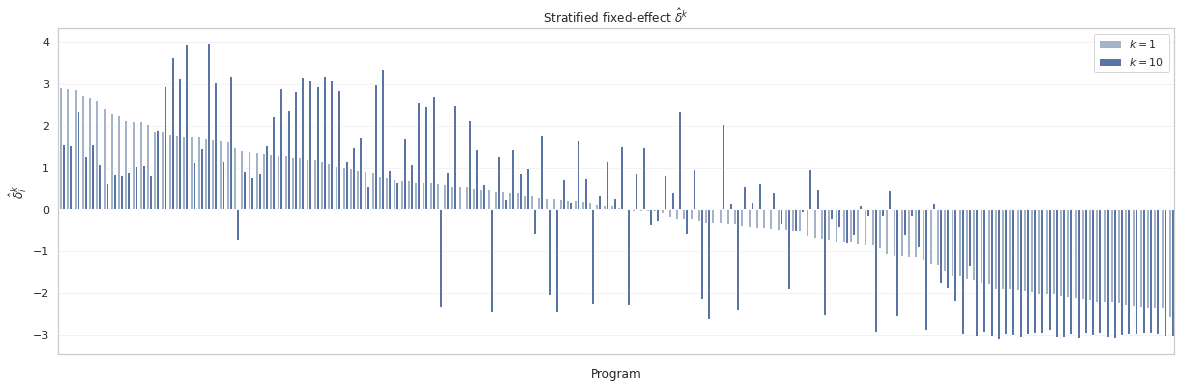

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))
pl_logits = pd.Series(model_dict['strat fixed'].logits[0].weight.detach().numpy()[:-1].flatten(), index=program_codex)
sorted_programs = pl_logits.sort_values(ascending=False).index

strat_logits = [pd.Series(model_dict['strat fixed'].logits[i].weight.detach().numpy()[:-1].flatten(), index=program_codex) for i in range(model_dict['strat fixed'].k)]
shifted_logits = [(logit - logit.mean()) for logit in strat_logits]
strat_logits_df = pd.DataFrame(shifted_logits).T.melt(ignore_index=False).reset_index()
strat_logits_df['bucket'] = strat_logits_df['variable'].map({i: '$k=$' + str(i+1) for i in range(10)})
sns.barplot(data=strat_logits_df[strat_logits_df.bucket.isin(['$k=$1', '$k=$10'])], 
            x='index', y='value', hue='bucket', order=sorted_programs, 
            palette=sns.light_palette(palette[1],n_colors=3)[-2:], ax=ax).set(xticklabels=[], 
                                                                                xlabel='Program', 
                                                                                ylabel='$\hat\delta^k_i$', 
                                                                                title='Stratified fixed-effect $\hat\delta^k$')
ax.legend()
fig.savefig('../Figs/strat_logits.pdf', format='pdf', bbox_inches='tight')

## Figure 9: Non-stratified coefficients, $\hat\beta$

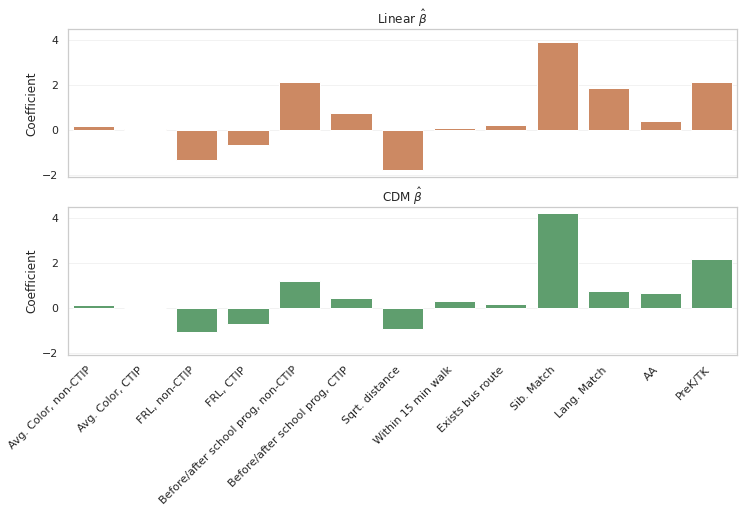

In [226]:
beta_linear = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['linear'].beta)])
beta_linear.columns=['coefficient','covariate','k']
beta_cdm = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['cdm'].beta)])
beta_cdm.columns=['coefficient','covariate','k']

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True, sharey=True)
sns.barplot(data = beta_linear, x='covariate', y='coefficient', color=palette[2], ax=ax[0]).set(
        title=r'Linear $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
sns.barplot(data = beta_cdm, x='covariate', y='coefficient', color=palette[3], ax=ax[1]).set(
        title=r'CDM $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
fig.savefig('../Figs/beta.pdf', format='pdf', bbox_inches='tight')

## Figure 10: Stratified coefficients, $\hat\beta^k$

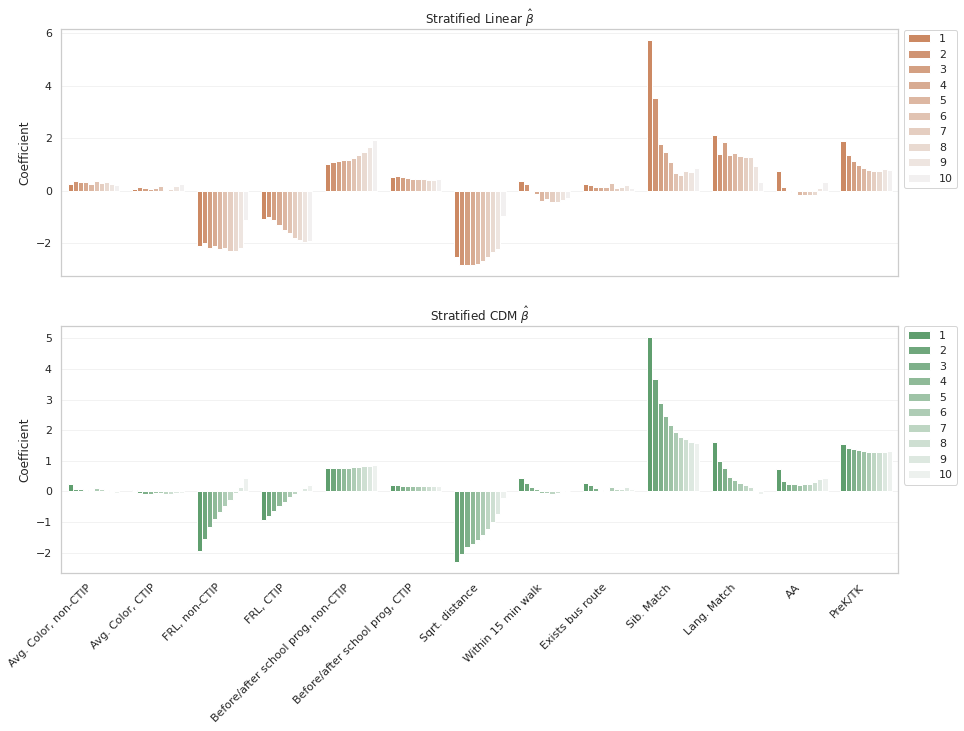

In [225]:
beta_linear = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['strat linear'].beta)])
beta_linear.columns=['coefficient','covariate','k']

beta_cdm = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['strat cdm'].beta)])
beta_cdm.columns=['coefficient','covariate','k']

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
sns.barplot(data = beta_linear, x='covariate', y='coefficient', hue='k', palette = sns.light_palette(palette[2],n_colors=10)[::-1], ax=ax[0]).set(
        title=r'Stratified Linear $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
sns.barplot(data = beta_cdm, x='covariate', y='coefficient', hue='k', palette = sns.light_palette(palette[3],n_colors=10)[::-1], ax=ax[1]).set(
        title=r'Stratified CDM $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient',
    )
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment': 'right'})
ax[0].legend(bbox_to_anchor=(1.0, 1.02))
ax[1].legend(bbox_to_anchor=(1.0, 1.02))
fig.savefig('../Figs/strat_beta.pdf', format='pdf', bbox_inches='tight')

## Figure 3: Non-stratified CDM contexts, $\hat U$

In [227]:
prog_mapping = pd.DataFrame({
    'program type': ['GE', 
                     'MM', 'MS', 'SA', 'AF', 'ED', 
                     'SN', 'SE', 'NS', 'SB',
                     'CE', 'CN', 'ME', 'MN', 'CT', 'NC', 'CB', 
                     'JN', 'JE', 
                     'KE', 'KN',
                     'DA', 'DT', 'FB'],
})
sort_mapping = prog_mapping.reset_index().set_index('program type')
program_attributes_train['program_num'] = program_attributes_train['program_type'].map(sort_mapping['index'])
program_attributes_train['logits'] = 0.0
program_attributes_train.loc[program_codex, 'logits'] = -pl_logits

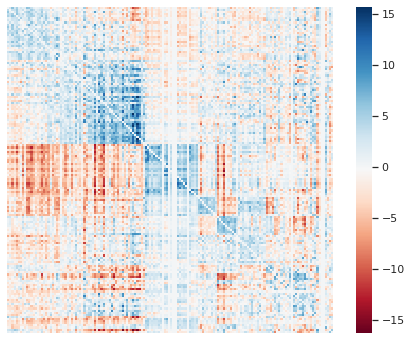

In [228]:
pl_logits = pd.Series(model_dict['fixed'].logits[0].weight.detach().numpy()[:-1].flatten(), index=program_codex)
pl_logits -= pl_logits.mean()

target = pd.DataFrame(model_dict['cdm'].target_embeddings[0].weight.detach().numpy()[:-1], index=program_codex)
context = pd.DataFrame(model_dict['cdm'].context_embeddings[0].weight.detach().numpy()[:-1], index=program_codex)
Ufull = target.values @ context.values.T
np.fill_diagonal(Ufull,0); Ufull -= Ufull.sum()/(num_programs*(num_programs-1)); np.fill_diagonal(Ufull,0)

Ufull_df = pd.DataFrame(Ufull, index=program_codex, columns=program_codex)
sorted_U_df = Ufull_df.loc[program_attributes_train.loc[program_codex].sort_values(by=['program_num', 'logits']).index, 
                           program_attributes_train.loc[program_codex].sort_values(by=['program_num', 'logits']).index]

fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(data=sorted_U_df, cmap='RdBu', square=True, xticklabels=False, yticklabels=False, ax=ax).set(xlabel='', ylabel='')
fig.savefig('../Figs/U_col.pdf', format='pdf', bbox_inches='tight')

# Figures 1, 2, 4, & 11: Loss evaluation

## Figure 1: NLL Loss

In [113]:
model_dict['nested'].scale_parameter.weight, nests

(Parameter containing:
 tensor([[0.7315],
         [0.6042],
         [0.5425],
         [0.4462],
         [0.6411],
         [0.5696],
         [0.2947]], requires_grad=True),
 ['Chinese Language',
  'Filipino Language',
  'General Education',
  'Japanese Language',
  'Korean Language',
  'Spanish Language',
  'Special Education'])

In [114]:
rank_results = full_train_df[(full_train_df['rank']!='all') & (full_train_df['loss type']!='train + reg')]
overall_results = full_train_df[(full_train_df['rank']=='all') & (full_train_df['loss type']!='train + reg')]

In [115]:
overall_results[overall_results['loss type']=='test']

model name  stratified loss type rank      loss  num epochs  no params  \
1           null       False      test  all  4.962845         0.0        0.0   
14         fixed       False      test  all  4.060420       137.0      155.0   
27   strat fixed        True      test  all  3.974716       151.0     1550.0   
40        linear       False      test  all  3.483318       163.0      168.0   
53  strat linear        True      test  all  3.331368       183.0     1680.0   
66           cdm       False      test  all  2.943985       293.0     3268.0   
79     strat cdm        True      test  all  2.859413       434.0    32680.0   
92        nested       False      test  all  3.449600       187.0      175.0   

     model  
1     null  
14   fixed  
27   fixed  
40  linear  
53  linear  
66     cdm  
79     cdm  
92  nested

/tmp/ipykernel_2964353/3134136167.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['null', 'fixed', 'fixed, strat.', 'linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'], fontdict={'horizontalalignment': 'right'})


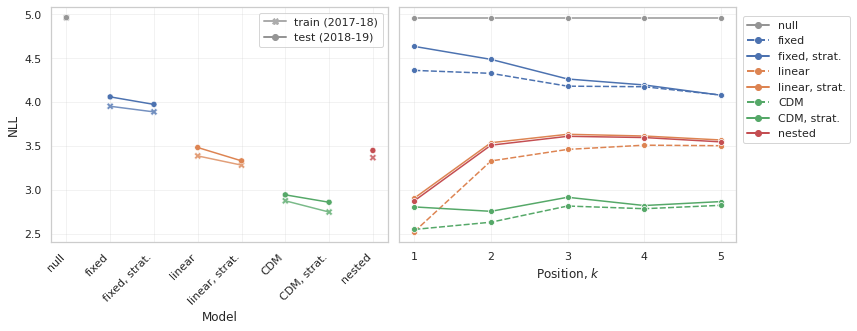

In [116]:
custom_lines_0 = [Line2D([0], [0], color=sns.light_palette(palette[0], n_colors=5)[3], linestyle='-', marker='X', lw=2),
                  Line2D([0], [0], color=sns.light_palette(palette[0], n_colors=5)[-1], linestyle='-', marker='o', lw=2)]
custom_lines_1 = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2)]

fig, ax = plt.subplots(1,2,figsize=(12,4.7),sharey=True)
sns.scatterplot(data=overall_results[(overall_results['loss type']=='train')], x='model name', y='loss', 
                hue='model', marker='X', s=50, alpha=0.8, palette=palette, ax=ax[0])
sns.scatterplot(data=overall_results[(overall_results['loss type']=='test')], x='model name', y='loss', 
                hue='model', marker='o', palette=palette, ax=ax[0])
ytrain=np.array([overall_results[(overall_results['model name']==model)&
                                 (overall_results['loss type']=='train')]['loss'].values for model in model_names]).flatten()
ytest=np.array([overall_results[(overall_results['model name']==model)&
                                (overall_results['loss type']=='test')]['loss'].values for model in model_names]).flatten()
sns.lineplot(x=[1,2], y=[ytrain[1], ytrain[2]], color=sns.light_palette(palette[1], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[1,2], y=[ytest[1], ytest[2]], color=palette[1], ax=ax[0])
sns.lineplot(x=[3,4], y=[ytrain[3], ytrain[4]], color=sns.light_palette(palette[2], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[3,4], y=[ytest[3], ytest[4]], color=palette[2], ax=ax[0])
sns.lineplot(x=[5,6], y=[ytrain[5], ytrain[6]], color=sns.light_palette(palette[3], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[5,6], y=[ytest[5], ytest[6]], color=palette[3], ax=ax[0])

sns.lineplot(data=rank_results[(rank_results['loss type']=='test')], 
             x='rank', y='loss', hue='model', style='stratified', palette=palette, marker='o', ax=ax[1])

ax[0].set_ylabel('NLL')
ax[0].set_xlabel('Model')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xticklabels(['null', 'fixed', 'fixed, strat.', 'linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'], fontdict={'horizontalalignment': 'right'})
ax[0].legend(custom_lines_0, ['train (2017-18)', 
                              'test (2018-19)'])
ax[1].set_xlabel(r'Position, $k$')
ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels([1,2,3,4,5])
ax[1].legend(custom_lines_1, ['null', 'fixed', 'fixed, strat.', 'linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'], loc=(1.02, 0.42))
fig.tight_layout()
fig.savefig('../Figs/nll_losses.pdf', format='pdf', bbox_inches='tight')

## Figures 4 & 11: Comparison w/ Nested

In [236]:
sample_student =  888006603
sample_student_id = student_codex_test.index(888006603)
top_choice = '420-MS-KG'
top_choice_id = program_codex.index(top_choice)

choice_set = list(np.arange(num_programs))
choice_set.remove(top_choice_id)
choice_set.append(num_programs)
x1 = t.Tensor(np.vstack([np.arange(num_programs)[None,:], np.array(choice_set)[None,:]])).long()
x2 = np.full((2,num_programs), fill_value=num_programs)
x2[1,0] = top_choice_id
x = t.Tensor(np.dstack([x1,x2])).long()
x_extra = t.tensor([[sample_student_id, num_programs, 0],[sample_student_id, num_programs-1, 1]])
likelihoods = np.exp(model_dict['linear'].forward(x, x_extra, X_test).detach().numpy()), np.exp(model_dict['nested'].forward(x, x_extra, X_test).detach().numpy()), np.exp(model_dict['cdm'].forward(x, x_extra, X_test).detach().numpy())
for likelihood in likelihoods:
    second_row = list(likelihood[1,:])
    second_row.insert(top_choice_id, 0.0)
    likelihood[1,:] = np.array(second_row[:-1])

In [237]:
probs_df_list = []
[probs_df_list.extend(zip([model]*likelihood.size, 
                          program_codex+program_codex, 
                          list(program_attributes_test.loc[program_codex, 'nest_membership'].values)+list(program_attributes_test.loc[program_codex, 'nest_membership'].values), 
                          ['top choice']*num_programs+['second choice']*num_programs, 
                          likelihood.flatten())) for model, likelihood in zip(['linear', 'nested', 'cdm'], likelihoods)]
probs_df = pd.DataFrame(probs_df_list, columns=['Model', 'Program', 'Nest Membership', 'Position', 'Probability'])
nest_order = ['Korean Language','Japanese Language','Filipino Language','Chinese Language','Spanish Language','General Education','Special Education']
probs_df['Nest Membership'] = pd.Categorical(probs_df['Nest Membership'], nest_order)
probs_df.head()

Model    Program    Nest Membership    Position  Probability
0  linear  413-GE-KG  General Education  top choice     0.010441
1  linear  413-SA-KG  Special Education  top choice     0.000028
2  linear  420-GE-KG  General Education  top choice     0.017339
3  linear  420-MS-KG  Special Education  top choice     0.000063
4  linear  420-SE-KG   Spanish Language  top choice     0.006944

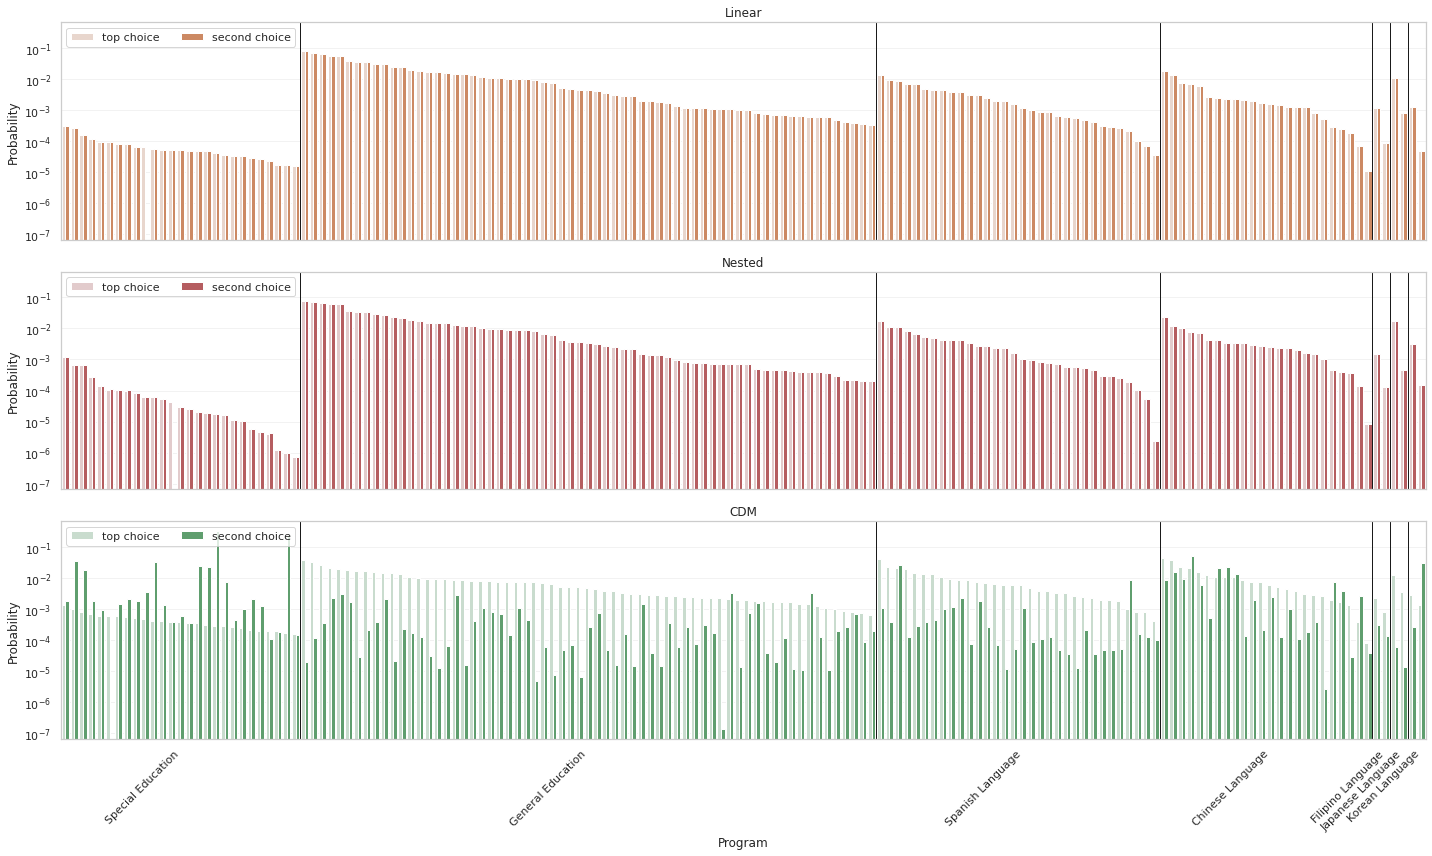

In [240]:
fig, ax = plt.subplots(3,1,figsize=(20,12),sharey=True,sharex=True)
sns.barplot(data = probs_df[(probs_df.Model=='linear')], x='Program', order=probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index, 
            y='Probability', hue='Position', palette=sns.light_palette(palette[2], n_colors=5)[1:5:3], ax=ax[0])
sns.barplot(data = probs_df[(probs_df.Model=='nested')], x='Program', order=probs_df[(probs_df.Model=='nested')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index, 
            y='Probability', hue='Position', palette=sns.light_palette(palette[-1], n_colors=5)[1:5:3], ax=ax[1])
sns.barplot(data = probs_df[(probs_df.Model=='cdm')], x='Program', order=probs_df[(probs_df.Model=='cdm')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index,
            y='Probability', hue='Position', palette=sns.light_palette(palette[3], n_colors=5)[1:5:3], ax=ax[2])
nest_value_counts = probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')]['Nest Membership'].value_counts()
for i in range(3):
    ax[i].set_yscale('log')
    # ax[i].set_ylim(1e-6,1.0)
    ax[i].set_xlabel('')
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-1]]-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-2:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-3:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-4:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-5:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-6:]].sum()-0.5, color='k', linewidth=1)
    ax[i].legend(loc='upper left', ncol=2)
ax[0].set_title(r'Linear')
ax[1].set_title(r'Nested')
ax[2].set_title(r'CDM')
ax[2].set_xticks(ticks = [nest_value_counts.loc[nest_order[-1]]//2, 
                          nest_value_counts.loc[nest_order[-1]]+nest_value_counts.loc[nest_order[-2]]//2, 
                          nest_value_counts.loc[nest_order[-2:]].sum()+nest_value_counts.loc[nest_order[-3]]//2,
                          nest_value_counts.loc[nest_order[-3:]].sum()+nest_value_counts.loc[nest_order[-4]]//2,
                          nest_value_counts.loc[nest_order[-4:]].sum()+nest_value_counts.loc[nest_order[-5]]//2,
                          nest_value_counts.loc[nest_order[-5:]].sum()+nest_value_counts.loc[nest_order[-6]]//2,
                          nest_value_counts.loc[nest_order[-6:]].sum()+nest_value_counts.loc[nest_order[-7]]//2],
                labels = nest_order[::-1])
ax[2].set_xlabel('Program')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
plt.tight_layout()
fig.savefig('../Figs/nested_probabilities.pdf', format='pdf', bbox_inches='tight')

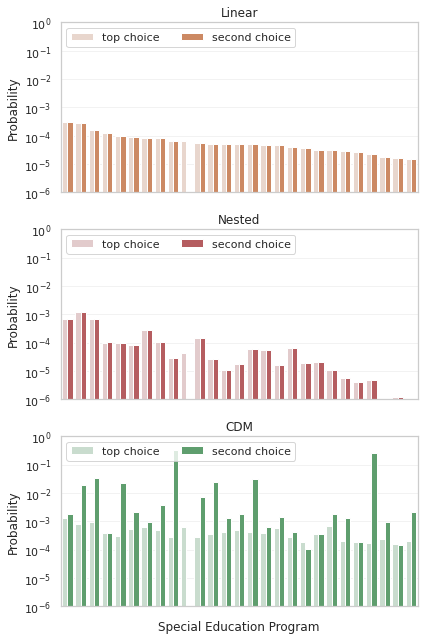

In [239]:
fig, ax = plt.subplots(3,1,figsize=(6,9),sharey=True,sharex=True)
xaxis_order = probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')&(probs_df['Nest Membership']=='Special Education')].sort_values(by='Probability', ascending=False).set_index('Program').index
sns.barplot(data = probs_df[(probs_df.Model=='linear')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[2], n_colors=5)[1:5:3], ax=ax[0])
sns.barplot(data = probs_df[(probs_df.Model=='nested')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[-1], n_colors=5)[1:5:3], ax=ax[1])
sns.barplot(data = probs_df[(probs_df.Model=='cdm')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[3], n_colors=5)[1:5:3], ax=ax[2])
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-6,1.0)
    ax[i].set_xlabel('')
    ax[i].legend(loc='upper left', ncol=2)
ax[0].set_title(r'Linear')
ax[1].set_title(r'Nested')
ax[2].set_title(r'CDM')
ax[2].set_xlabel('Special Education Program')
ax[2].set_xticklabels([])
plt.tight_layout()
fig.savefig('../Figs/nested_probabilities_speced.pdf', format='pdf', bbox_inches='tight')

## Figure 2: Top-K CDM

In [ ]:
def top_k_cdm(k, num_ranks=5):
    result=[]    
    train = pd.concat([df for df in folds])

    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = dp.prep_dataset(train, program_attributes_train)
    X_train = generate_covariate_matrix(program_attributes_train, train_st_codex, train_prog_codex, train_ctip_codex)
    (xtest, xltest, ytest), test_st_codex, test_ctip_codex = dp.prep_valset(dataset_test, program_attributes_test, train_prog_codex)
    X_test = generate_covariate_matrix(program_attributes_test, test_st_codex, train_prog_codex, test_ctip_codex)
    
    kwargs={'fixed_effects': True,
            'linear_terms': True,
            'covariates': X_train,
            'context': True,
            'embedding_dim': 10,
            'top_k': k,
            'num_ranks': num_ranks}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=1e-3, wd=1e-5, verbose=True, **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
    tr_losses = np.array(tr_losses)
    result.append(['cdm', False, k, 'train', 'all', float(tr_loss), num_epochs, no_params])

    ytest_hat = model.forward(xtest, xltest, X_test)
    test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
    result.append(['cdm', False, k, 'test', 'all', float(test_loss), num_epochs, no_params])
    for j in range(num_ranks):
        result.append(['cdm', False, k, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
        result.append(['cdm', False, k, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
    return result

In [ ]:
top_k_cdm_results = Parallel(n_jobs=-4)(delayed(top_k_cdm)(k) for k in np.arange(5)+1)
top_k_cdm_df = pd.DataFrame([subitem for result in top_k_cdm_results for subitem in result], 
                             columns=['model name', 'stratified', 'k', 'loss type', 'rank', 'loss', 'num epochs', 'no params'])

In [ ]:
temp_palette = [palette[3],sns.light_palette(palette[3], n_colors=5)[2]]
custom_lines = [Line2D([0], [0], color=temp_palette[1], linestyle='', marker='X', lw=2),
                Line2D([0], [0], color=temp_palette[0], linestyle='', marker='o', lw=2)]

fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=overall_results[overall_results['model name']=='linear'], 
                x=0, y='loss', hue='loss type', style='loss type', palette=temp_palette, legend=False, ax=ax)
sns.scatterplot(data=top_k_cdm_df[top_k_cdm_df['rank']=='all'], 
                x='k', y='loss', hue='loss type', style='loss type', palette=temp_palette, ax=ax)
sns.scatterplot(data=overall_results[overall_results['model name']=='cdm'], 
                x=8, y='loss', hue='loss type', style='loss type', palette=temp_palette, legend=False, ax=ax)
ax.set_ylabel('NLL')
ax.set_ylim(2.8,3.6)
ax.set_xlabel(r'Position, $k$')
ax.legend(custom_lines, ['train (2017-18)', 'test (2018-19)'])
ax.set_xticks([0,1,2,3,4,5,8])
ax.set_xticklabels([0,1,2,3,4,5,r'm'])
fig.savefig('../Figs/top_k_cdm.pdf', format='pdf', bbox_inches='tight')

# Figures 5 & 12: Accuracy

## Figure 5: Accuracy at $k$

In [62]:
def generate_DA_inputs(dataset, stud_codex, codex, program_data, compute_travel_times=False):
    '''
    Must have 'ranked_schools_codex', and 'r1_randomnumber_adjusted' fields in the dataset.
    '''
    n=len(codex)
    assert(dataset.shape[0]==len(stud_codex))
    StudPrefs = np.full(fill_value=n, shape=(dataset.shape[0], n))
    StudentPrts = np.zeros((dataset.shape[0], n))
    for ind, row in dataset.iterrows():
        student_id = int(row['student_id'])
        programs = row['r1_ranked_programs'] if len(row['r1_ranked_programs'])!=0 else row['r2_ranked_programs'] if len(row['r2_ranked_programs'])!=0 else row['r3_ranked_programs'] if len(row['r3_ranked_programs'])!=0 else row['r4_ranked_programs'] if len(row['r4_ranked_programs'])!= 0 else row['r5_ranked_programs']
        StudPrefs[student_id, :len(programs)] = [codex.index(program) for program in programs]
        sibling, aaprek, aa = row['sibling'], row['aaprek'], row['idschoolattendance']
        sib_programs, aaprek_programs = [], []
        [sib_programs.extend(list(program_data[program_data.school_id==school].index.values)) for school in sibling]
        index_sibling = [codex.index(program) for program in sib_programs if program in codex]
        [aaprek_programs.extend(list(program_data[program_data.school_id==school].index.values)) for school in aaprek]
        index_aaprek = [codex.index(program) for program in aaprek_programs if program in codex]
        index_aa = [codex.index(program) for program in program_data[program_data.school_id==aa].index.values if program in codex]
        '''
        Encode priorities as follows:
        Sibling  +16
        AA Prek  +8
        CTIP1    +4
        AA       +2
        Tiebreak +random number
        '''
        StudentPrts[student_id, index_sibling] += 16.
        StudentPrts[student_id, index_aaprek] += 8.
        if row['ctip1']:
            StudentPrts[student_id] += 4.
        StudentPrts[student_id, index_aa] += 2.
    SchoolCaps = program_data.loc[codex, 'capacity'].values
    return SchoolCaps, StudentPrts, StudPrefs


In [63]:
df_test['student_id']=[student_codex_test.index(studid) if studid in student_codex_test else None for studid in df_test['studentno']]
subset_df_test = df_test.dropna(subset=['student_id'])

/tmp/ipykernel_2964353/1481570219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['student_id']=[student_codex_test.index(studid) if studid in student_codex_test else None for studid in df_test['studentno']]


In [64]:
SchoolCaps_test, StudentPrts_test, StudPrefs_test = generate_DA_inputs(subset_df_test, student_codex_test, program_codex, program_attributes_test)

In [99]:
def generate_one(i, model_name, model, program_attributes, student_codex, program_codex, ctip_codex, prefs, rank, return_mode=False):
    '''
    Generates rank-position choice given prior rank choices in prefs.
    '''
    random.seed(model_name+str(i))
    n_students = len(student_codex)
    n_programs = len(program_codex)
    
    preferences = copy.deepcopy(prefs)
    next_open_slot = np.argmax(preferences==n_programs, axis=1)
    assert(max(next_open_slot)<=rank)
    rows_to_sample = (next_open_slot==rank)
    X_sample = generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex)
    
    if model_name=='null':
        probs = np.divide(np.ones((n_students, n_programs+1)), (preferences==n_programs).sum(1)[:,None])
        probs[np.arange(n_students)[:,None], preferences]=0.
        preferences[rows_to_sample, rank] = probs[rows_to_sample,:].argmax(axis=1) if return_mode else t.multinomial(t.Tensor(probs)[rows_to_sample,:], num_samples=1).flatten()
        return model_name, preferences
    elif model_name == 'nested':
        num_agents, num_alternatives, num_features = X_sample.shape
        pad_mat = np.zeros((num_agents, num_features), dtype=np.float32)
        X_sample = np.hstack([X_sample, pad_mat[:,None,:]]) # add zeros matrix to second dimension of covariates (column-wise)

        X_sample = t.from_numpy(X_sample)
        x = t.from_numpy(np.tile(np.arange(n_programs+1)[None,:], (n_students,1)))
        x[np.arange(n_students)[:,None], preferences[:,:rank]] = n_programs
        
        x_extra = t.from_numpy(np.arange(n_students))
        C = t.ones((n_students, n_programs+1))
        C[np.arange(n_students)[:,None], preferences[:,:rank]]=0.
        probs = model.compute_nested_probabilities(x[:,:-1], x_extra, C[:,:-1], X_sample, sampling=True)
        probs = t.mul(probs,C[:,:-1])
        if t.any(t.all(probs<=0., dim=1)):
            print('Found all 0s row')
            print(np.where(t.all(probs<=0., dim=1)))
        preferences[rows_to_sample,rank] = (probs[rows_to_sample]).argmax(axis=1).flatten() if return_mode else t.multinomial(probs[rows_to_sample],num_samples=1).flatten()
        return model_name, preferences
    else:
        k=model.k
        utilities = t.zeros((n_students, n_programs))
        if model.fixed_effects:
            utilities[rows_to_sample] += model.logits[min(k-1, rank)].weight.detach().numpy()[:-1].flatten()[None,:]
        else: 
            pass
        if model.linear_terms:
            beta = model.beta[min(k-1, rank)].weight.detach().numpy().flatten()
            utilities[rows_to_sample]+=X_sample[rows_to_sample]@beta #n_stud x n_prog
        else: 
            pass
        if (rank>0) & model.context:
            T = model.target_embeddings[min(k-1, rank)].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
            C = model.context_embeddings[min(k-1, rank)](preferences[rows_to_sample,:rank]).detach().numpy() # num_students, rank, embedding_dim
            avg_C = C.mean(axis=-2) # num_students, embedding_dim
            avg_interactions = (avg_C @ T.T)
            utilities[rows_to_sample] += avg_interactions
        else:
            pass
        utilities = np.concatenate((utilities, np.full((n_students, 1), fill_value=-np.inf)), axis=1)
        utilities[np.arange(n_students)[:,None], preferences[:,:rank]]=-np.inf
        viable_softmax_probs = softmax(utilities[rows_to_sample], axis=1)
        preferences[rows_to_sample,rank] = viable_softmax_probs.argmax(axis=1) if return_mode else t.multinomial(t.Tensor(viable_softmax_probs), num_samples=1).flatten()
        return model_name, preferences



In [100]:
num_samples=100
input_prefs = np.full((len(student_codex_test), num_programs), fill_value=num_programs)
modal_results = {rank: [] for rank in range(10)}
sample_results = {rank: [] for rank in range(10)}
for rank in tqdm(range(10)):
    input_prefs[:,:rank] = StudPrefs_test[:,:rank]
    sample_results[rank]=Parallel(n_jobs=-4)(delayed(generate_one)(k, model_name, model_dict[model_name], program_attributes_test, student_codex_test, program_codex, 
                                                                  ctip_codex_test, input_prefs, rank) 
                                            for model_name in model_names
                                            for k in range(num_samples))
    modal_results[rank]=Parallel(n_jobs=-4)(delayed(generate_one)(0, model_name, model_dict[model_name], program_attributes_test, student_codex_test, program_codex, 
                                                                  ctip_codex_test, input_prefs, rank, return_mode=True) 
                                                 for model_name in model_names)

100%|██████████| 10/10 [16:18<00:00, 97.88s/it]


In [101]:
results_modal = {i: {model: [] for model in model_names} for i in range(10)}
results_sample = {i: {model: [] for model in model_names} for i in range(10)}
for i in range(10):
    [results_modal[i][name].append(pref) for name, pref in modal_results[i]]
    [results_sample[i][name].append(pref) for name, pref in sample_results[i]]

In [102]:
def agreement(rank, model_name, array):
    inds = (array[:, rank]!=num_programs) & (StudPrefs_test[:, rank]!=num_programs)
    return rank, model_name, (array[inds,rank]==StudPrefs_test[inds,rank]).mean(), sum(inds)

agreement_results=Parallel(n_jobs=-4)(delayed(agreement)(rank, model_name, array)
                                        for rank in range(10) 
                                        for model_name in model_names 
                                        for array in results_modal[rank][model_name])
modal_agreements=pd.DataFrame(agreement_results, columns=['rank position', 'model name', 'agreement w true', 'no. eligible ballots'])

In [103]:
modal_agreements[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in modal_agreements['model name']]

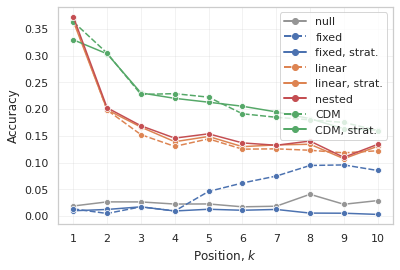

In [231]:
custom_lines = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
fig, ax=plt.subplots(1,1)
sns.lineplot(data=modal_agreements, x='rank position', y='agreement w true', hue='model', style='stratified', palette=palette, marker='o', ax=ax)
ax.set_xticks(np.arange(10), np.arange(10)+1)
ax.legend(custom_lines, ['null', 
                         'fixed', 'fixed, strat.', 
                         'linear', 'linear, strat.',
                         'nested',
                         'CDM', 'CDM, strat.'], loc='upper right')
ax.set_ylabel('Accuracy')
ax.set_xlabel(r'Position, $k$')
fig.savefig('../Figs/accuracy_at_k.pdf', format='pdf', bbox_inches='tight')

## Figure 12: By subpopulation

In [106]:
school_codex = program_attributes_test.loc[program_codex, 'school_id'].unique()

In [107]:
reindexed_df = subset_df_test.set_index('studentno').loc[student_codex_test]
reindexed_df['top_ranked_prog'] = 0
for ind, row in reindexed_df.iterrows():
    round_idx = row['first_participated_round']
    programs = row['r'+str(round_idx)+'_programs']
    reindexed_df.loc[ind, 'top_ranked_prog'] = programs[0]
those_who_ranked_lang_first = reindexed_df['top_ranked_prog'].isin(program_to_language.keys())
those_who_ranked_gened_first = reindexed_df['top_ranked_prog']=='GE'
those_who_ranked_speced_first = ~(those_who_ranked_lang_first|those_who_ranked_gened_first)
assert(all((those_who_ranked_lang_first|those_who_ranked_gened_first)|those_who_ranked_speced_first))
those_with_siblings = (reindexed_df['sibling'].str.len()!=0).values
those_with_aaprek = (reindexed_df['aaprek'].str.len()!=0).values
those_with_aa = (~reindexed_df['idschoolattendance'].isna()).values
print('AA:\t\t', those_with_aa.mean())
print('Sibling:\t', those_with_siblings.mean())
print('CTIP1:\t\t', np.array(ctip_codex).mean())
print('AAPrek:\t\t', those_with_aaprek.mean())
print('Lang First:\t', those_who_ranked_lang_first.mean())
print('GenEd First:\t', those_who_ranked_gened_first.mean())
print('SpecEd First:\t', those_who_ranked_speced_first.mean())


AA:		 1.0
Sibling:	 0.3002347417840376
CTIP1:		 0.16676628810520025
AAPrek:		 0.034976525821596244
Lang First:	 0.336150234741784
GenEd First:	 0.6525821596244131
SpecEd First:	 0.011267605633802818


In [108]:
def agreement(rank, model_name, array, level='program', subpop=None, subset=None):
    if subset is None:
        subset=np.full(StudPrefs_test.shape[0], fill_value=True)
    inds = subset & (array[:, rank]!=num_programs) & (StudPrefs_test[:, rank]!=num_programs)
    if level=='program':
        result = (array[inds,rank]==StudPrefs_test[inds,rank]).mean()
    elif level=='school':
        modal_programs = array[inds,rank]
        modal_schools = program_attributes_test.loc[np.array(program_codex)[modal_programs], 'school_id']
        true_programs = StudPrefs_test[inds,rank]
        true_schools = program_attributes_test.loc[np.array(program_codex)[true_programs], 'school_id']
        result = (modal_schools.values==true_schools.values).mean()
    else:
        return None
    return rank, model_name, level, subpop, result, sum(inds)

In [210]:
subpop_agreement_results=Parallel(n_jobs=-4)(delayed(agreement)(rank, model_name, array, level, subpop, subset)
                                             for model_name in model_names
                                             for rank in [0,1,2]
                                             for level in ['program', 'school']
                                             for array in results_modal[rank][model_name]
                                             for subpop, subset in [('AA', those_with_aa),
                                                                    ('Sibling', those_with_siblings),
                                                                    ('CTIP1', ctip_codex_test), 
                                                                    ('PreK/TK', those_with_aaprek),
                                                                    ('Asian', (reindexed_df.resolved_ethnicity=='Asian').values),
                                                                    ('Hisp./Latino', (reindexed_df.resolved_ethnicity=='Hispanic/Latino').values),
                                                                    ('N/A', (reindexed_df.resolved_ethnicity=='Decline to State').values),
                                                                    ('White', (reindexed_df.resolved_ethnicity=='White').values),
                                                                    ('Two or More', (reindexed_df.resolved_ethnicity=='Two or More Races').values),
                                                                    ('Black or A.A.', (reindexed_df.resolved_ethnicity=='Black or African American').values),
                                                                    ('Gen. Ed.', those_who_ranked_gened_first),
                                                                    ('Language', those_who_ranked_lang_first),
                                                                    ('Spec. Ed.', those_who_ranked_speced_first)])
subpop_modal_agreements = pd.DataFrame(subpop_agreement_results, columns=['rank position', 'model name', 'level', 'subpopulation', 'accuracy', 'no. eligible ballots'])

In [211]:
subpop_modal_agreements[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in subpop_modal_agreements['model name']]

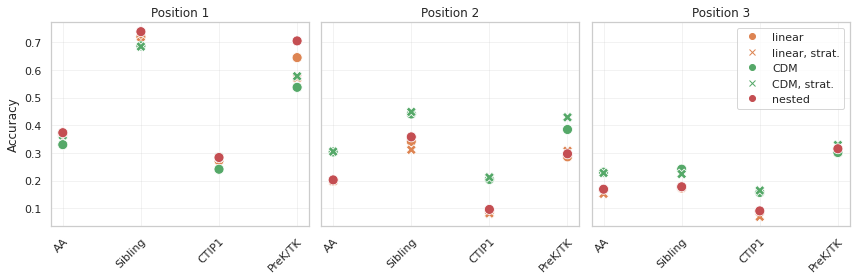

In [232]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
data = subpop_modal_agreements[(subpop_modal_agreements.model.isin(['linear', 'cdm', 'nested'])) & (subpop_modal_agreements.level=='program') & (subpop_modal_agreements.subpopulation.isin(['AA', 'Sibling', 'CTIP1', 'PreK/TK']))]
sns.scatterplot(data=data[data['rank position']==0], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[0])
sns.scatterplot(data=data[data['rank position']==1], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[1])
sns.scatterplot(data=data[data['rank position']==2], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[2])
ax[0].set_title('Position 1')
ax[1].set_title('Position 2')
ax[2].set_title('Position 3')
ax[0].set_ylabel('Accuracy')
for i in range(3):
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
custom_points = [Line2D([0], [0], marker='o', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='o', color=palette[3], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[3], lw=0), 
                 Line2D([0], [0], marker='o', color=palette[4], lw=0)]
ax[2].legend(custom_points, ['linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'])
plt.tight_layout()
fig.savefig('../Figs/by_subpopulation_priority.pdf', format='pdf', bbox_inches='tight')


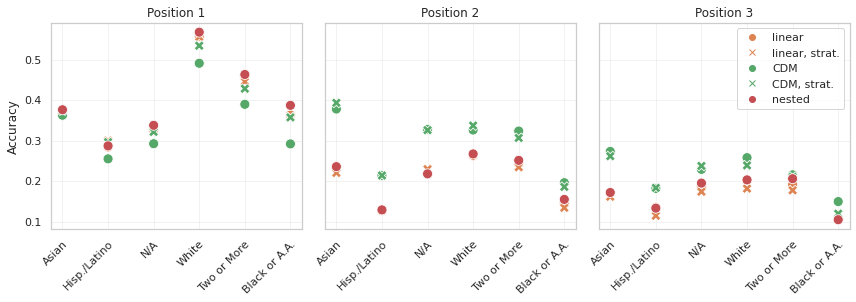

In [233]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4.3))
data = subpop_modal_agreements[(subpop_modal_agreements.model.isin(['linear', 'cdm', 'nested'])) & (subpop_modal_agreements.level=='program') & (subpop_modal_agreements.subpopulation.isin(['Asian', 'Hisp./Latino', 'N/A', 'White', 'Two or More', 'Black or A.A.']))]
sns.scatterplot(data=data[data['rank position']==0], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[0])
sns.scatterplot(data=data[data['rank position']==1], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[1])
sns.scatterplot(data=data[data['rank position']==2], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[2])
ax[0].set_title('Position 1')
ax[1].set_title('Position 2')
ax[2].set_title('Position 3')
ax[0].set_ylabel('Accuracy')
for i in range(3):
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
ax[2].legend(custom_points, ['linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'])
plt.tight_layout()
fig.savefig('../Figs/by_subpopulation_demo.pdf', format='pdf', bbox_inches='tight')


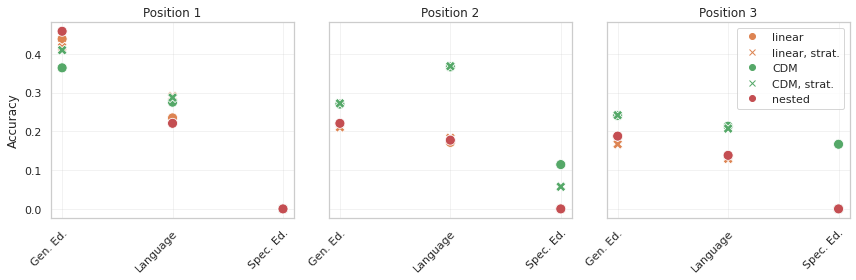

In [234]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
data = subpop_modal_agreements[(subpop_modal_agreements.model.isin(['linear', 'cdm', 'nested'])) & (subpop_modal_agreements.level=='program') & (subpop_modal_agreements.subpopulation.isin(['Gen. Ed.', 'Language', 'Spec. Ed.']))]
sns.scatterplot(data=data[data['rank position']==0], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[0])
sns.scatterplot(data=data[data['rank position']==1], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[1])
sns.scatterplot(data=data[data['rank position']==2], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:], s=100, ax=ax[2])
ax[0].set_title('Position 1')
ax[1].set_title('Position 2')
ax[2].set_title('Position 3')
ax[0].set_ylabel('Accuracy')
for i in range(3):
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
ax[2].legend(custom_points, ['linear', 'linear, strat.', 'CDM', 'CDM, strat.', 'nested'])
plt.tight_layout()
fig.savefig('../Figs/by_subpopulation_firstprog.pdf', format='pdf', bbox_inches='tight')


# Figure 13: Correlation & consistency

## Kendall's $\tau$ correlations

In [159]:
def generate_full_preferences(i, model_name, model, program_attributes, student_codex, program_codex, ctip_codex):
    '''
    Generates preferences that are either sampled from the distribution or the modal selection 
    (highest probability alternative) at each rank position.
        - model is of StratifiedLinear class.
        - student_codex is in travel_times.index
        - program_codex is same as used for training
    '''
    random.seed(model_name+str(i))
    n_students = len(student_codex)
    n_programs = len(program_codex)
    preferences=t.zeros((n_students, n_programs),dtype=int)
    X_sample = generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex)

    if model is None:
        probs=t.ones((n_students, n_programs))/float(n_programs)
        preferences = t.multinomial(probs, num_samples=n_programs, replacement=False)
        return model_name, preferences
    
    elif model_name == 'nested':
        num_agents, num_alternatives, num_features = X_sample.shape
        pad_mat = np.zeros((num_agents, num_features), dtype=np.float32)
        X_sample = np.hstack([X_sample, pad_mat[:,None,:]]) # add zeros matrix to second dimension of covariates (column-wise)

        X_sample = t.from_numpy(X_sample)
        x = t.from_numpy(np.tile(np.arange(n_programs)[None,:], (n_students,1)))
        x_extra = t.from_numpy(np.arange(n_students))
        C = t.ones((n_students, n_programs))
        for i in range(n_programs):
            probs = model.compute_nested_probabilities(x, x_extra, C, X_sample, sampling=True)
            selections = t.multinomial(probs, num_samples=1).flatten()
            preferences[:,i] = selections
            x[np.arange(n_students), selections] = n_programs
            C[np.arange(n_students), selections] = 0.
        return model_name, preferences
    
    else:
        for i in range(model.k-1):
            utilities = t.zeros((n_students, n_programs))
            if model.fixed_effects:
                logits = model.logits[i].weight.detach().numpy()[:-1].flatten()
                utilities += logits[None,:]

            if model.linear_terms:
                linear = X_sample@model.beta[i].weight.detach().numpy().flatten()
                utilities += linear

            if (i>0) & model.context:
                T = model.target_embeddings[i].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
                C = model.context_embeddings[i](preferences[:,:i]).detach().numpy() # num_students, i, embedding_dim
                avg_C = C.mean(axis=-2) # num_students, embedding_dim
                avg_interactions = (avg_C @ T.T)
                utilities += avg_interactions
            utilities[np.arange(n_students)[:,None], preferences[:,:i]]=-np.inf
            softmax_probs = softmax(utilities, axis=1)
            preferences[:,i] = t.multinomial(softmax_probs, num_samples=1).flatten()

        utilities = t.zeros((n_students, n_programs))
        if model.fixed_effects:
            logits = model.logits[-1].weight.detach().numpy()[:-1].flatten()
            utilities += logits[None,:]

        if model.linear_terms:
            linear = X_sample@model.beta[-1].weight.detach().numpy().flatten()
            utilities += linear

        if model.context:
            T = model.target_embeddings[-1].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
            for i in range(model.k-1,n_programs):
                if i>0:
                    C = model.context_embeddings[-1](preferences[:,:i]).detach().numpy() # num_students, i, embedding_dim
                    avg_C = C.mean(axis=-2) # num_students, embedding_dim
                    avg_interactions = (avg_C @ T.T)
                    utilities += avg_interactions
                utilities[np.arange(n_students)[:,None], preferences[:,:i]] = -np.inf
                softmax_probs = softmax(utilities, axis=1)
                preferences[:,i] = t.multinomial(softmax_probs, num_samples=1).flatten()
        else:
            utilities[np.arange(n_students)[:,None], preferences[:,:(model.k-1)]] = -np.inf
            softmax_probs = softmax(utilities, axis=1)
            preferences[:,(model.k-1):] = t.multinomial(softmax_probs,num_samples=n_programs-(model.k-1),replacement=False)

        return model_name, preferences

In [160]:
num_samples=100
sample_results = Parallel(n_jobs=-4)(delayed(generate_full_preferences)(i, 
                                                                        model_name, 
                                                                        model_dict[model_name],
                                                                        program_attributes_test,
                                                                        student_codex_test, 
                                                                        program_codex, 
                                                                        ctip_codex_test) 
                                     for i in range(num_samples) 
                                     for model_name in model_names)
sampled_preferences = {key: [] for key in model_dict.keys()}
[sampled_preferences[name].append(prefs) for name, prefs in sample_results]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [163]:
stacked_sampled_prefs = {}
for key, value in sampled_preferences.items():
    stacked_sampled_prefs[key]=np.dstack(value)

In [164]:
sampled_preferences_rank = {key: [array.argsort(axis=1) for array in sampled_preferences[key]] for key in model_names}

In [165]:
def kendall_tau_wrapper(model1, model2, array1, array2, num_rows):
    rows_id = random.sample(range(array1.shape[0]), num_rows)
    corr_list=[]
    for row in rows_id:
        corr_list.append(weightedtau(array1[row], array2[row])[0])
    return model1, model2, corr_list

In [166]:
num_rows_to_sample = 1000
result = Parallel(n_jobs=-4)(delayed(kendall_tau_wrapper)(model1, model2, sampled_preferences_rank[model1][k], sampled_preferences_rank[model2][k+1], num_rows_to_sample)
                             for model1, model2 in itertools.combinations_with_replacement(sampled_preferences_rank.keys(), r=2)
                             for k in range(num_samples-1))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [188]:
weighted_kt_df = pd.DataFrame(0, index=sampled_preferences_rank.keys(), columns=sampled_preferences_rank.keys())
for model1, model2, corr_list in result:
    total = np.array(corr_list).sum()
    weighted_kt_df.loc[model2, model1] += total
weighted_kt_matrix = (weighted_kt_df / (num_rows_to_sample * (num_samples-1))).values

/tmp/ipykernel_2964353/367540473.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(weighted_kt_matrix, dtype=np.bool)


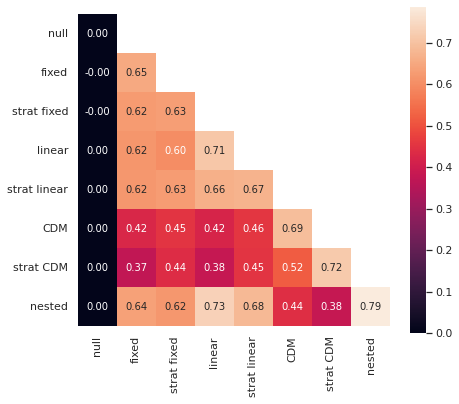

In [229]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
mask = np.zeros_like(weighted_kt_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)
sns.heatmap(weighted_kt_matrix, 
            xticklabels=['null', 
                         'fixed', 'strat fixed', 
                         'linear', 'strat linear',
                         'CDM', 'strat CDM', 
                         'nested'], 
            yticklabels=['null', 
                         'fixed', 'strat fixed', 
                         'linear', 'strat linear',
                         'CDM', 'strat CDM', 
                         'nested'], 
            mask=mask, 
            square=True,
            annot=True,
            fmt='.2f', ax=ax)
fig.savefig('../Figs/correlations.pdf', format='pdf', bbox_inches='tight')

## Consistency at $k$

In [190]:
def consistency(rank, model_name, arr1, arr2):
    inds = (arr1[:, rank]!=num_programs) & (arr2[:, rank]!=num_programs)
    return rank, model_name, (arr1[inds,rank]==arr2[inds,rank]).mean(), sum(inds)
consistency_results=Parallel(n_jobs=-4)(delayed(consistency)(rank, model_name, arr1, arr2)
                                        for rank in range(10) 
                                        for model_name in model_names
                                        for arr1, arr2 in itertools.combinations(results_sample[rank][model_name], r=2))
consistencies=pd.DataFrame(consistency_results, columns=['rank position', 'model name', 'consistency', 'no. eligible ballots'])
consistencies[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in consistencies['model name']]

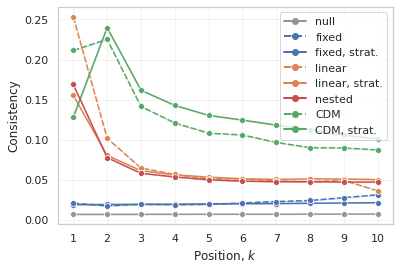

In [230]:
custom_lines = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
fig, ax=plt.subplots(1,1)
sns.lineplot(data=consistencies, x='rank position', y='consistency', hue='model', style='stratified', 
             palette=palette, marker='o', ax=ax)
ax.set_xticks(np.arange(10), np.arange(10)+1)
ax.set_ylabel('Consistency')
ax.set_xlabel(r'Position, $k$')
ax.legend(custom_lines, ['null', 
                         'fixed', 'fixed, strat.', 
                         'linear', 'linear, strat.', 
                         'nested',
                         'CDM', 'CDM, strat.'], loc='upper right')
fig.savefig('../Figs/consistencies.pdf', format='pdf', bbox_inches='tight')